### ISC CamCan Suspense

The goal of this notebook is to run a sliding-window ISC 

### setting up modules

In [1]:
import numpy as np
import os, sys, scipy, nilearn, warnings#, brainiak
import numpy as np
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import pandas as pd
warnings.filterwarnings("ignore")
#from brainiak import isfc
from scipy import stats
from camcan_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

/Users/Ralf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### set up files

In [2]:
suspense_file = '../data/avg_suspense.npy'
dict_file     = '../data/timeseries_dictionary.npy'
ts_data_file  = '../data/ts_data.npy'

### load data 
see description in notebook on main ISC analysis

In [3]:
ts_data = np.load(ts_data_file)
n_tr, n_regions, n_subjs = ts_data.shape

### compute dynamic ISC analysis

In [4]:
winSize = 30
step = 1
numOfChunks = int((n_tr - winSize)/step ) 
print(numOfChunks)

163


In [7]:
dyn_isc_result_all = np.zeros((n_regions, numOfChunks))

# change e.g. n_subjs = 30  to speed up computation - but don't overwrite the output...
D = ts_data[:,:,:n_subjs] 
print('Calculating ISC on ', D.shape[1], ' voxels/regions and ', D.shape[2], ' subjects over ', numOfChunks, ' windows.'   )
    
slide_isc_node_seg_mean = np.zeros((n_regions,numOfChunks))
onsets = np.arange(0,numOfChunks*step, step)  
    
for curr_win in range(0,numOfChunks):    
        this_onset = onsets[curr_win]
        D_seg_data = D[this_onset:(this_onset+winSize), : , :]
        ISC = camcan_isc(D_seg_data, summary_statistic=np.mean, verbose = False)
        ISC[np.isnan(ISC)] = 0
        dyn_isc_result_all[:, curr_win] = ISC 

        progress = 100 * ( curr_win/numOfChunks)
        sys.stdout.write("\r%d%%" % progress)
        sys.stdout.flush()   

Calculating ISC on  268  voxels/regions and  494  subjects over  163  windows.
99%

In [8]:
# if precomputed
#dyn_isc_file  = '../data/dyn_isc_dict.npy'
#dyn_isc_dict = np.load(dyn_isc_file).item() 
#dyn_isc_result_all = dyn_isc_dict['dyn_isc_result_all']
#dyn_isc_result = dyn_isc_dict['dyn_isc_result_splithalf']

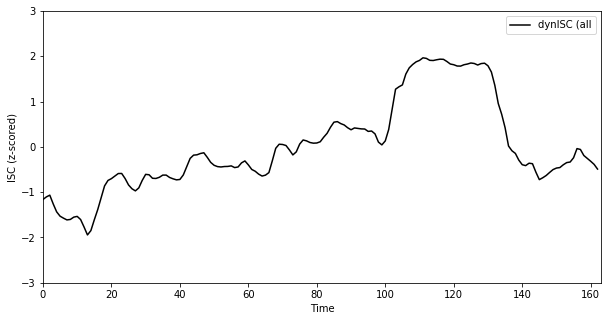

In [9]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result_all[:,:], axis = 0)), color = 'black', label = 'dynISC (all');
plt.legend();
plt.xlim(0, 163);
plt.ylim(-3, 3);
plt.xlabel('Time');
plt.ylabel('ISC (z-scored)');

#### set up two sub-samples (for consistency check)

In [10]:
subject_chunks = [[0, int(n_subjs/2)],
                  [int(n_subjs/2), n_subjs]]
n_iterations = len(subject_chunks)
dyn_isc_result = np.zeros((n_iterations, n_regions, numOfChunks))

sub_index = np.arange(n_subjs)
np.random.shuffle(sub_index)

for curr_sample in range(n_iterations): 
    print('Working on subgroup #', (curr_sample +1 ), ' of ', n_iterations)
    people_to_use = np.arange(subject_chunks[curr_sample][0], subject_chunks[curr_sample][1], 1)
    #print(people_to_use)
    #print(sub_index[people_to_use])
    
    D = ts_data[:,:,sub_index[people_to_use] ]
    print('Calculating ISC on ', D.shape[1], ' voxels/regions and ', D.shape[2], ' subjects over ', numOfChunks, ' windows.'   )
    
    slide_isc_node_seg_mean = np.zeros((n_regions,numOfChunks))
    onsets = np.arange(0,numOfChunks*step, step)  
    
    for curr_win in range(0,numOfChunks):    
        this_onset = onsets[curr_win]
        D_seg_data = D[this_onset:(this_onset+winSize), :, :]
        ISC = camcan_isc(D_seg_data, summary_statistic=np.mean, verbose = False)
        ISC[np.isnan(ISC)] = 0
        slide_isc_node_seg_mean[:, curr_win] = ISC 

        progress = 100 * ( curr_win/numOfChunks)
        sys.stdout.write("\r%d%%" % progress)
        sys.stdout.flush()

    dyn_isc_result[curr_sample, :, :] = slide_isc_node_seg_mean

Working on subgroup # 1  of  2
Calculating ISC on  268  voxels/regions and  247  subjects over  163  windows.
99%Working on subgroup # 2  of  2
Calculating ISC on  268  voxels/regions and  247  subjects over  163  windows.
99%

Alignment: 0.54


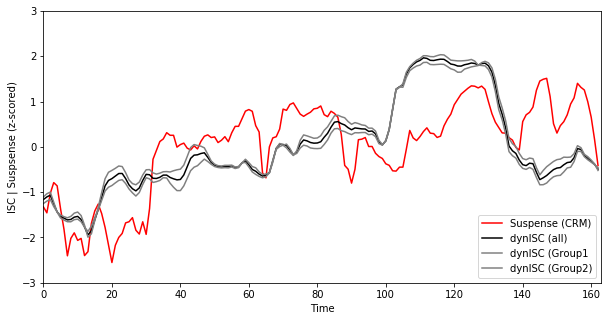

In [11]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)

suspense = np.load(suspense_file)
ax1.plot(scipy.stats.zscore(suspense),   color = 'red',   label = 'Suspense (CRM)' );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result_all[:,:], axis = 0)), color = 'black', label = 'dynISC (all)'   );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result[0,:,:], axis = 0)),   color = 'gray',  label = 'dynISC (Group1' );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result[1,:,:], axis = 0)),   color = 'gray',  label = 'dynISC (Group2)');

plt.legend(loc = 4)
plt.xlim(0, 163)
plt.ylim(-3, 3)
plt.xlabel('Time')
plt.ylabel('ISC | Suspsense (z-scored)')

alignment = np.corrcoef(
                (scipy.stats.zscore(np.nanmean(dyn_isc_result_all[:,:], axis =0)) ),
                 scipy.signal.resample(scipy.stats.zscore(suspense), 163) )[0,1]

print('Alignment: ' + str(np.round(alignment, 2)) )

In [12]:
#suspense_raw = '../data/suspense.npy'
#all_suspense = np.load(suspense_raw)
#all_suspense = all_suspense[:,50:2440] 
#ms = np.mean(all_suspense, axis=0)
#ms193 = scipy.signal.resample(ms, 193)

Alignment: 0.73


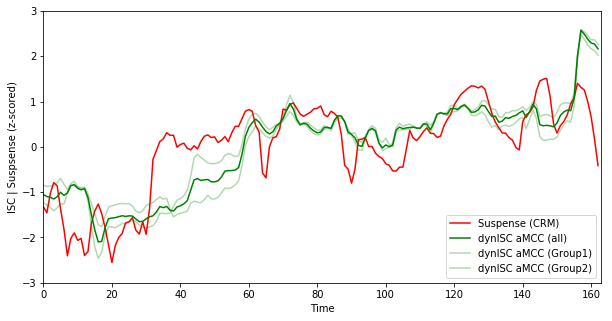

In [13]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)

ax1.plot(scipy.stats.zscore(suspense), color = 'red',   label = 'Suspense (CRM)');
ax1.plot(scipy.stats.zscore(dyn_isc_result_all[14,:]),             color = 'green', label = 'dynISC aMCC (all)');
ax1.plot(scipy.stats.zscore(dyn_isc_result[0,14,:]).T,             color = 'green', alpha = 0.3, label = 'dynISC aMCC (Group1)');
ax1.plot(scipy.stats.zscore(dyn_isc_result[1,14,:]).T,            color = 'green',  alpha = 0.3, label = 'dynISC aMCC (Group2)');

plt.legend(loc = 4)
plt.xlim(0, 163)
plt.ylim(-3, 3)
plt.xlabel('Time')
plt.ylabel('ISC | Suspsense (z-scored)')

alignment = np.corrcoef(
                (scipy.stats.zscore(dyn_isc_result_all[14,:]) ),
                 scipy.signal.resample(scipy.stats.zscore(suspense), 163) )[0,1]

print('Alignment: ' + str(np.round(alignment,2)) )

#### save results

because computing them every time from scratch takes a lot of time we save the output here so we can load it quicker later on

In [14]:
dyn_isc_dict = {}
dyn_isc_dict['dyn_isc_result_all'] = dyn_isc_result_all
dyn_isc_dict['dyn_isc_result_splithalf'] = dyn_isc_result

np.save('../data/dyn_isc_dict.npy', dyn_isc_dict) 